# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть

Сегодня мы поговорим о генеративно-состязательных нейросетях. Они же:
* генеративные соревновательные сети
* порождающие соперничающие сети
* порождающие соревнующиеся сети

#### Примеры работы GAN:
* https://www.thispersondoesnotexist.com/ - генерация несуществующих лиц
* https://thiscatdoesnotexist.com/ - генерация несуществующих котов (ошибки в генерации котов: https://aiweirdness.com/post/182633984547/gancats)
* https://www.youtube.com/watch?v=PCBTZh41Ris - генерация танцевальных движений


#### Генеративно-состязательная сеть (англ. Generative adversarial network)
— алгоритм машинного обучения без учителя, построенный на комбинации из двух нейронных сетей, одна из которых (сеть $G$, генератор) генерирует образцы，а другая (сеть $D$, дискриминатор) старается отличить правильные («подлинные») образцы от неправильных. https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

Если совсем коротко, то:

$$\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]$$

Где: 
* $x$ - реальные данные из обучающй выборки
* $D(x)$ - результат работы дискриминатора, т.е. вероятность того, что перед нами несгенерированные данные
* $z$ - случайный вектор фиксированной длины, выбранный из нормального распределения
* $G(z)$ - сгенерированные из $z$ данные

Задача для $G$ - генерировать данные $p_g$ с таким же распределением как и у реальных данных  $p_{data}$ .
Цель $D$ же - отличать сгенерированные данные от оригиналов. 
Тогда $D(G(z))$ - вероятность того, что данные из генератора являются реальными. Идеальный результат обучения GAN - $p_{data} = p_g$

### Дискриминатор ($D$)

Модель дискриминатора берет входные данные (реальные или сгенерированный) и предсказывает к какому из этих двух классов принадлежат эти данные.
Обучение сводится к минимизация функции потерь.

После процесса обучения модель дискриминатора отбрасывается, поскольку нас уже интересует только генерация данных.

### Генератор ($G$)

Задача генератора - создавать «поддельные» изображения, похожие на те, что в обучающей выборке. 
Во время обучения генератор постоянно пытается обыграть дискриминатор, улучшая качество подделок.


### Vanilla GAN

Рассмотрим реализацю самой первой статьи по GAN'ам на классическом датасете MNIST 

Generative Adversarial Nets Ian J. Goodfellow (2014) https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf  

![GANs_%D1%81%D1%85%D0%B5%D0%BC%D0%B0.png](attachment:GANs_%D1%81%D1%85%D0%B5%D0%BC%D0%B0.png)

Подключаем нужные модули и библиотеки

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [3]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Параметры для обучения обеих моделей

In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


#### ... Небольшое отступление 
Создание своих слоев

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

#### nn.init
https://pytorch.org/docs/stable/nn.init.html

Дискриминатор 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Загрузка датасета

In [ ]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

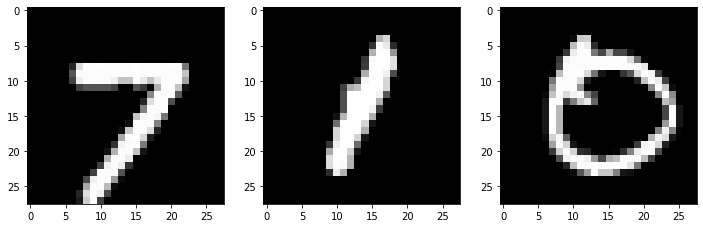

In [ ]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

Инициализация

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 18/200] [Batch 916/938] [D loss: 0.319099] [G loss: 2.669308]


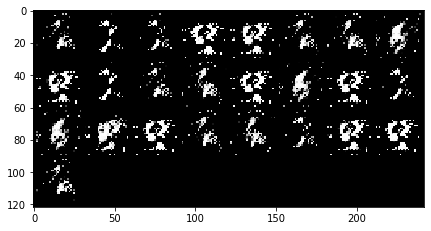

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

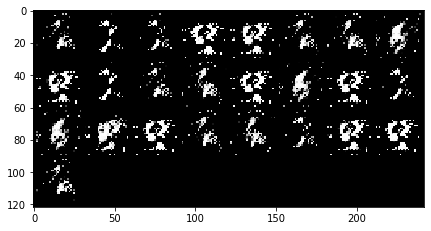

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

Анимация первых 88 эпох обучения

![myimage.gif](attachment:myimage.gif)

In [ ]:
torch.save(generator.state_dict(), "vanilla_gan.pth")

https://medium.com/@jonathan_hui

Домашнее задание: 

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю
 

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.




In [5]:
x = np.linspace(1,30,2)
def func_y(x):
    return np.sin(x)/x - x/10
print("Func_y:", func_y(x))    

Func_y: [ 0.74147098 -3.03293439]


In [7]:
train_data_length = 512
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = func_y(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]

In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
        output = self.model(x)
        

        return output

In [17]:
discriminator = Discriminator()

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output



In [19]:
generator = Generator()

In [20]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [26]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [27]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.70412677526474
Epoch: 0 Loss G.: 0.6479371786117554
Epoch: 10 Loss D.: 0.7102339863777161
Epoch: 10 Loss G.: 0.7077499628067017
Epoch: 20 Loss D.: 0.67521733045578
Epoch: 20 Loss G.: 0.7999065518379211
Epoch: 30 Loss D.: 0.6823394298553467
Epoch: 30 Loss G.: 0.6981488466262817
Epoch: 40 Loss D.: 0.6955453157424927
Epoch: 40 Loss G.: 0.7264102697372437
Epoch: 50 Loss D.: 0.6943596005439758
Epoch: 50 Loss G.: 0.6791555881500244
Epoch: 60 Loss D.: 0.6930822134017944
Epoch: 60 Loss G.: 0.6851394176483154
Epoch: 70 Loss D.: 0.6870280504226685
Epoch: 70 Loss G.: 0.7148464322090149
Epoch: 80 Loss D.: 0.6840909719467163
Epoch: 80 Loss G.: 0.7117919921875
Epoch: 90 Loss D.: 0.6787430644035339
Epoch: 90 Loss G.: 0.6844430565834045
Epoch: 100 Loss D.: 0.6948435306549072
Epoch: 100 Loss G.: 0.6997455954551697
Epoch: 110 Loss D.: 0.6884331107139587
Epoch: 110 Loss G.: 0.7099593281745911
Epoch: 120 Loss D.: 0.6928345561027527
Epoch: 120 Loss G.: 0.6931604743003845
Epoch: 130 Loss

In [28]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

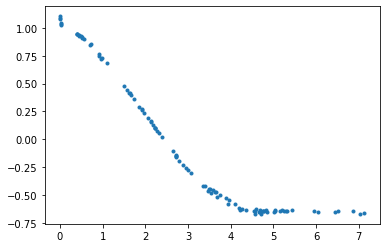

In [29]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

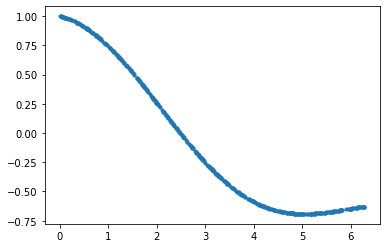

In [8]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")